# Extract deep coadds

 work with Weakly_2024_07
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/22
- update : 2024/03/01


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2024_07/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2024_07/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2024_07/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+903d45c1e3 	current w_2024_08 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.daf.base as dafBase

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch
# Astropy
from astropy.visualization import ZScaleInterval, AsinhStretch

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import pprint

In [6]:
#Set the matplotlib plot color table.
plt.style.use('tableau-colorblind10')
import seaborn as sns

In [7]:
# Let us also set `lsst.afw.display` to use the `matplotlib` backend:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

## Give the collection

In [9]:
#my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"

In [10]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

## Config

In [11]:
#all_tracts = np.array([5616, 5634, 5615, 10644, 383, 8188, 3863, 455, 452, 5839, 10643, 382])
all_tracts = [382,383,452,455,
                     3863,3864,
                     5614,5615,5616,5634,5839,
                     #8188,
                     10643,10644]

## List of deep coadds

In [12]:
datasetRefs = registry.queryDatasets(datasetType='deepCoadd', collections=my_collection, where= "instrument='LATISS'")
for i, ref in enumerate(datasetRefs):
    print(f"========({i})================datasetType = deepCoadd ============================================")
    print("fullId..................:",ref.dataId.full)
    print("band....................:",ref.dataId["band"])
    print("skymap..................:",ref.dataId["skymap"])
    print("tract..................:",ref.dataId["tract"])
    print("patch..................:",ref.dataId["patch"])
    print("run.....................:",ref.run)

========(0)================datasetType = deepCoadd ============================================
fullId..................: {band: 'r', skymap: 'latiss_v1', tract: 5615, patch: 292}
band....................: r
skymap..................: latiss_v1
tract..................: 5615
patch..................: 292
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240207T032325Z
========(1)================datasetType = deepCoadd ============================================
fullId..................: {band: 'y', skymap: 'latiss_v1', tract: 3864, patch: 237}
band....................: y
skymap..................: latiss_v1
tract..................: 3864
patch..................: 237
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240207T032325Z
========(2)================datasetType = deepCoadd ============================================
fullId..................: {band: 'z', skymap: 'latiss_v1', tract: 455,

/tmp/ipykernel_54286/599058660.py:4: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)


## Select a tract and a band

In [13]:
index_sel = 5
tract_sel = all_tracts[index_sel]
band_sel = "i"

## Load deepCoadds

In [14]:
datasetRefs = registry.queryDatasets(datasetType='deepCoadd', collections=my_collection, where= "instrument='LATISS'")
all_dataId = []
all_deepcoadds  = []
all_titles = []
all_patches = []
all_deepCoadd_wcs = []
all_deepCoadd_bbox = []
all_deepCoadd_corners_ra= []
all_deepCoadd_corners_dec = []
all_xvals = []
all_yvals = []
all_str_tract_patch = []

for i, ref in enumerate(datasetRefs):

    band = ref.dataId["band"]
    tract = ref.dataId["tract"]
    patch = ref.dataId["patch"]
    skymap = ref.dataId["skymap"]

    if band == band_sel and tract == tract_sel:
        print(f"========({i})================datasetType = deepCoadd ============================================")
        print("fullId..................:",ref.dataId.full)
        print("band....................:",ref.dataId["band"])
        print("skymap..................:",ref.dataId["skymap"])
        print("tract..................:",ref.dataId["tract"])
        print("patch..................:",ref.dataId["patch"])
        print("run.....................:",ref.run)
    
        
        
        the_dataId = {'skymap':skymap,'band': band, 'tract': tract, 'patch': patch}
        the_title = f"Auxtel deepCoadd : band={band}, tract={tract}, patch={patch}" 
        my_deepCoadd = butler.get('deepCoadd', dataId=ref.dataId.full,collections=my_collection)

        #my_deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=ref.dataId.full)
        #my_deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=ref.dataId.full)
        my_deepCoadd_wcs = my_deepCoadd.wcs
        my_deepCoadd_bbox = my_deepCoadd.getBBox() 
        my_deepCoadd_corners_ra, my_deepCoadd_corners_dec = get_corners_radec(my_deepCoadd_wcs, my_deepCoadd_bbox)
        my_xvals = [my_deepCoadd_corners_ra[0], my_deepCoadd_corners_ra[1], my_deepCoadd_corners_ra[2], \
             my_deepCoadd_corners_ra[3], my_deepCoadd_corners_ra[0]]
        my_yvals = [my_deepCoadd_corners_dec[0], my_deepCoadd_corners_dec[1], my_deepCoadd_corners_dec[2], \
             my_deepCoadd_corners_dec[3], my_deepCoadd_corners_dec[0]]

        str_tract_patch = '(' + str(ref.dataId['tract']) + ', ' + str(ref.dataId['patch'])+')'
        
        all_dataId.append(the_dataId) 
        all_patches.append(ref.dataId["patch"])
        all_deepcoadds.append(my_deepCoadd)
        all_titles.append(the_title)
        all_deepCoadd_wcs.append( my_deepCoadd_wcs)
        all_deepCoadd_bbox.append(my_deepCoadd_bbox)
        all_deepCoadd_corners_ra.append(my_deepCoadd_corners_ra)
        all_deepCoadd_corners_dec.append(my_deepCoadd_corners_dec)
        all_xvals.append(my_xvals)
        all_yvals.append(my_yvals)
        all_str_tract_patch.append(str_tract_patch)  
    else:
        pass
    

========(9)================datasetType = deepCoadd ============================================
fullId..................: {band: 'i', skymap: 'latiss_v1', tract: 3864, patch: 275}
band....................: i
skymap..................: latiss_v1
tract..................: 3864
patch..................: 275
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240207T032325Z


/tmp/ipykernel_54286/2720093231.py:23: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_54286/2720093231.py:34: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  my_deepCoadd = butler.get('deepCoadd', dataId=ref.dataId.full,collections=my_collection)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-8.0.0/Linux64/daf_butler/gb06f0c56ff+74dfa3d8fc/python/lsst/daf/butler/dimensions/_coordinate.py:993: FutureWarning: Call to deprecated function (or staticmethod) graph. (DataCoordinate.graph is deprecated in favor of .dimensions, and will be dropped after v27.) -- Deprecated since version v27.
  return self._target.graph.dimensions
/opt/lsst/so

========(14)================datasetType = deepCoadd ============================================
fullId..................: {band: 'i', skymap: 'latiss_v1', tract: 3864, patch: 273}
band....................: i
skymap..................: latiss_v1
tract..................: 3864
patch..................: 273
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240207T032325Z
========(62)================datasetType = deepCoadd ============================================
fullId..................: {band: 'i', skymap: 'latiss_v1', tract: 3864, patch: 235}
band....................: i
skymap..................: latiss_v1
tract..................: 3864
patch..................: 235
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240207T032325Z
========(64)================datasetType = deepCoadd ============================================
fullId..................: {band: 'i', skymap: 'latiss_v1', tract: 3

## Summaries

In [15]:
N = len(all_deepcoadds)
for index in range(N):
    print(index,all_titles[index])

0 Auxtel deepCoadd : band=i, tract=3864, patch=275
1 Auxtel deepCoadd : band=i, tract=3864, patch=273
2 Auxtel deepCoadd : band=i, tract=3864, patch=235
3 Auxtel deepCoadd : band=i, tract=3864, patch=217
4 Auxtel deepCoadd : band=i, tract=3864, patch=256
5 Auxtel deepCoadd : band=i, tract=3864, patch=219
6 Auxtel deepCoadd : band=i, tract=3864, patch=254
7 Auxtel deepCoadd : band=i, tract=3864, patch=237
8 Auxtel deepCoadd : band=i, tract=3864, patch=218
9 Auxtel deepCoadd : band=i, tract=3864, patch=255
10 Auxtel deepCoadd : band=i, tract=3864, patch=238
11 Auxtel deepCoadd : band=i, tract=3864, patch=216
12 Auxtel deepCoadd : band=i, tract=3864, patch=274
13 Auxtel deepCoadd : band=i, tract=3864, patch=236
14 Auxtel deepCoadd : band=i, tract=3864, patch=257


In [16]:
all_patches = np.array(all_patches)
list_patches = np.unique(all_patches)

In [17]:
all_dataId

[{'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 275},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 273},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 235},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 217},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 256},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 219},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 254},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 237},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 218},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 255},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 238},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 216},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 274},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3864, 'patch': 236},
 {'skymap': 'latiss_v1', 'band': 'i', 'tract': 3

## Plot patchs

In [18]:
nPatches = len(list_patches)
sns.color_palette("hls", nPatches)
cmap = ListedColormap(sns.color_palette("hls", nPatches))

In [19]:
patch_to_color = {}
patch_flagplot = {}
for idx,patch in enumerate(all_patches):
    patch_to_color[patch] = cmap.colors[idx]
    patch_flagplot[patch] = False 

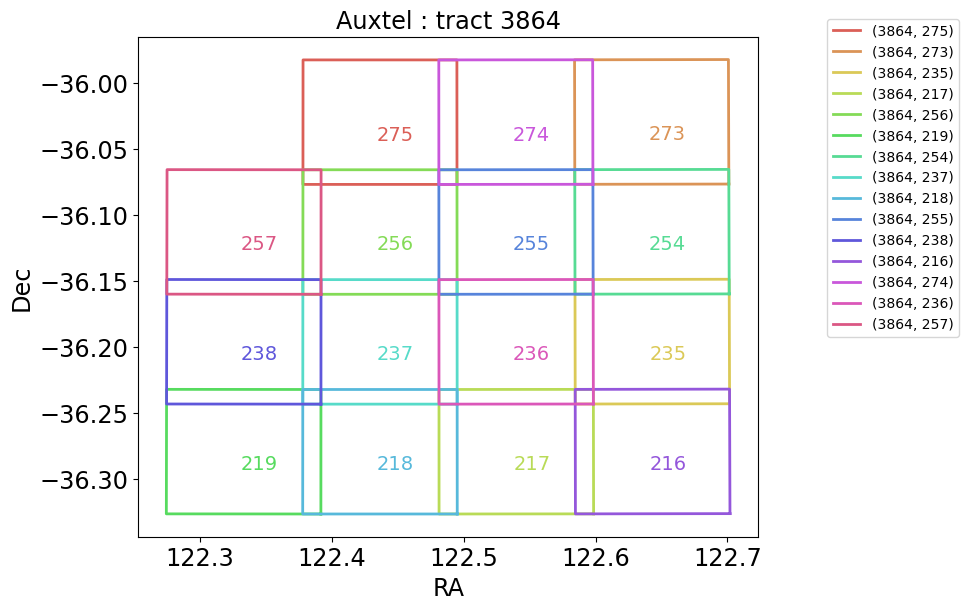

In [20]:
fig = plt.figure(figsize=(8, 8))

for idx,dataid in enumerate(all_dataId):  
    patch = dataid['patch']
    if not patch_flagplot[patch]:
        xvals = np.array(all_xvals[idx])
        yvals = np.array(all_yvals[idx])
        xmean = xvals.mean()
        ymean = yvals.mean()
        
        str_tract_patch = all_str_tract_patch[idx]
        color = patch_to_color[patch]
        plt.plot(xvals, yvals, ls='solid', lw=2, color=color,label=str_tract_patch)
        patch_flagplot[patch] = True
        plt.text(xmean,ymean, str(patch),
                 verticalalignment='center', horizontalalignment='center', 
                 color=color,size=14)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=1)
the_title_tract = f"Auxtel : tract {tract_sel}"
plt.title(the_title_tract)
plt.gca().set_aspect('equal')
plt.show()

## plot deepCoadd

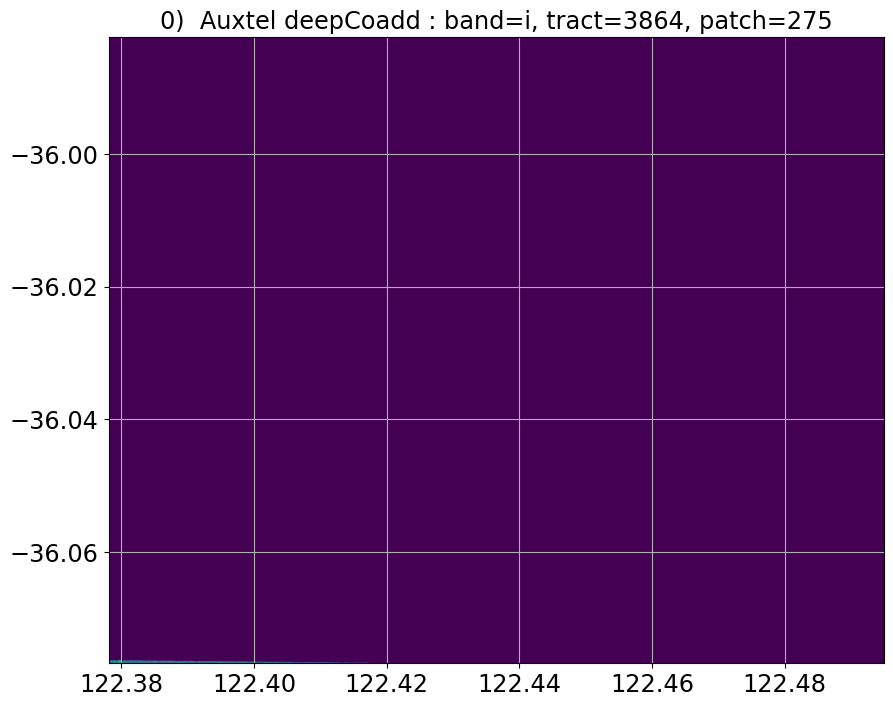

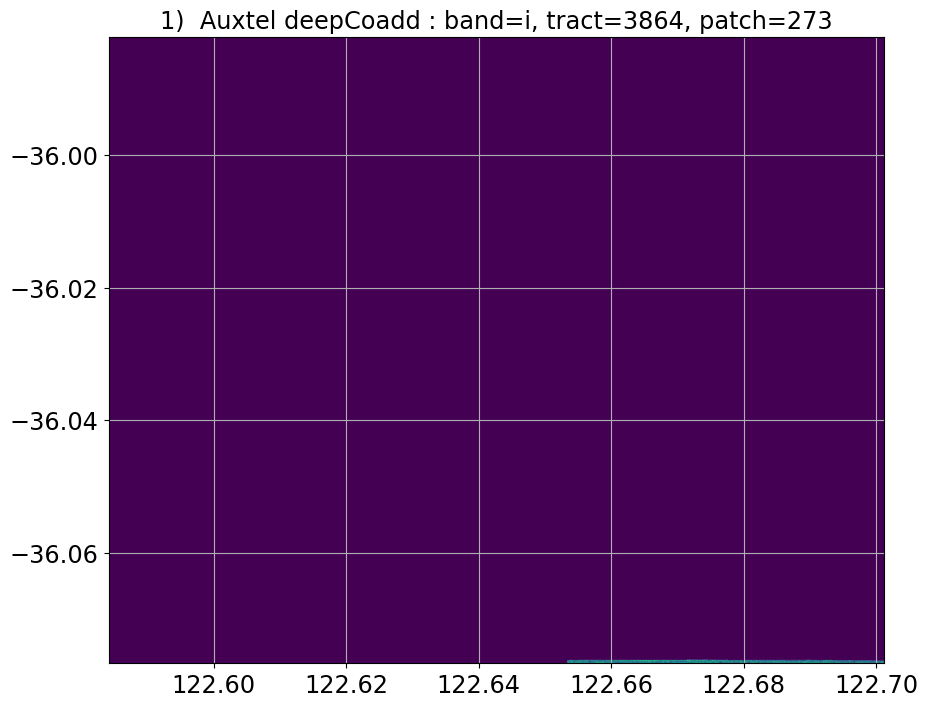

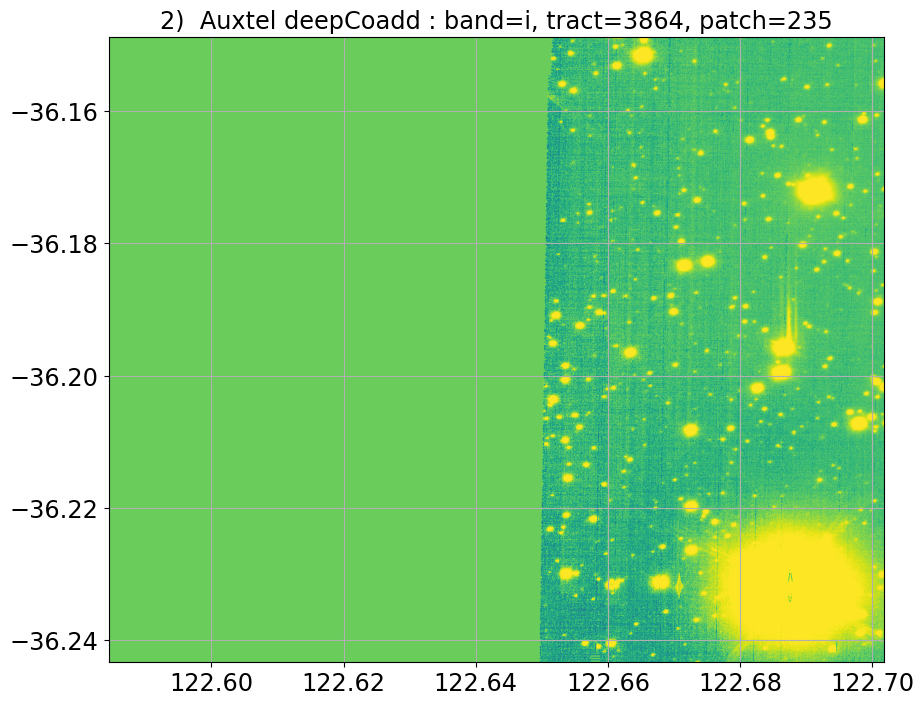

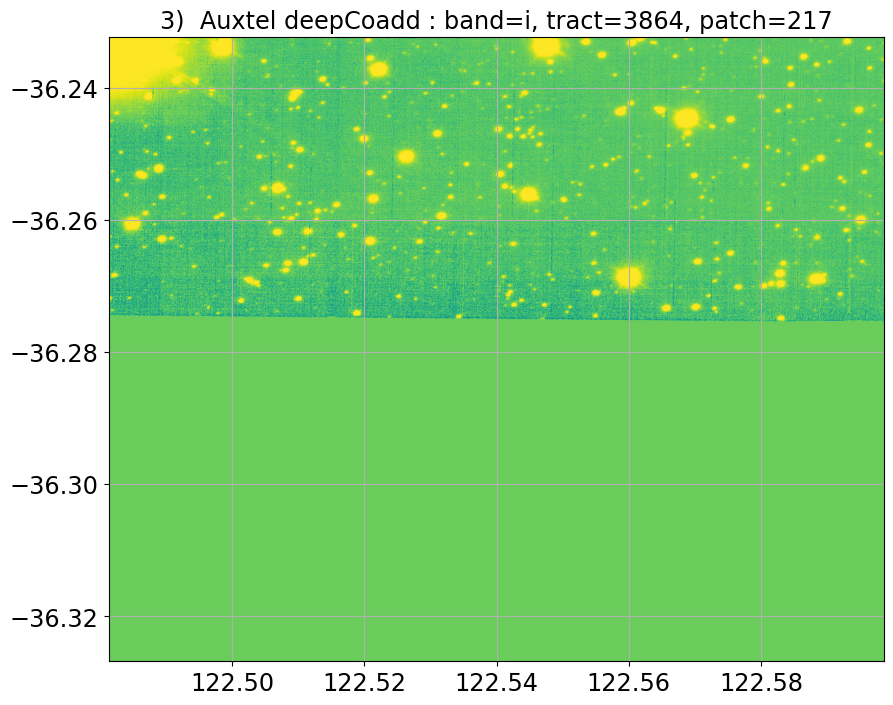

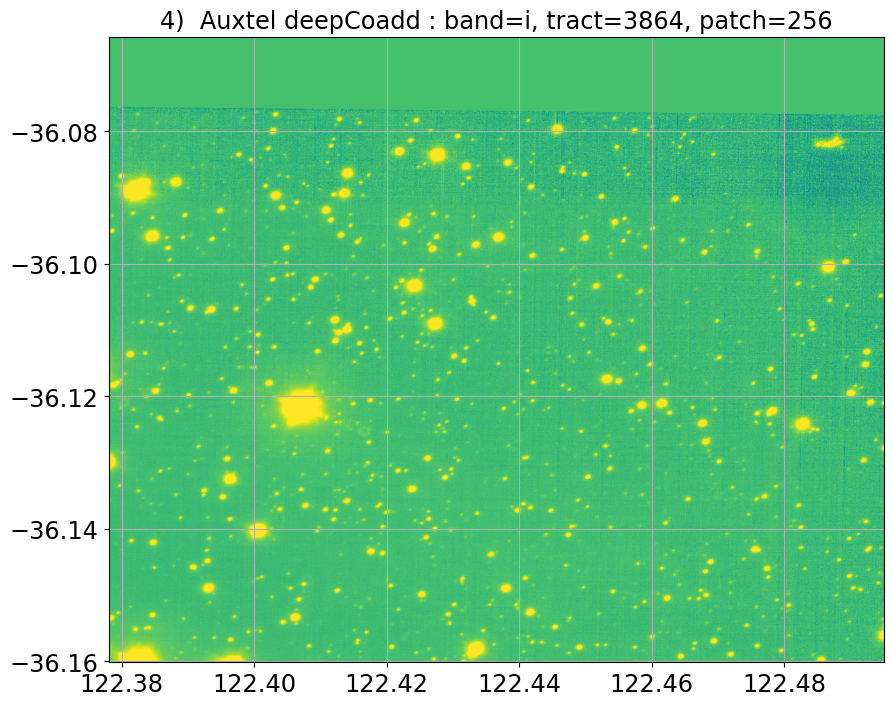

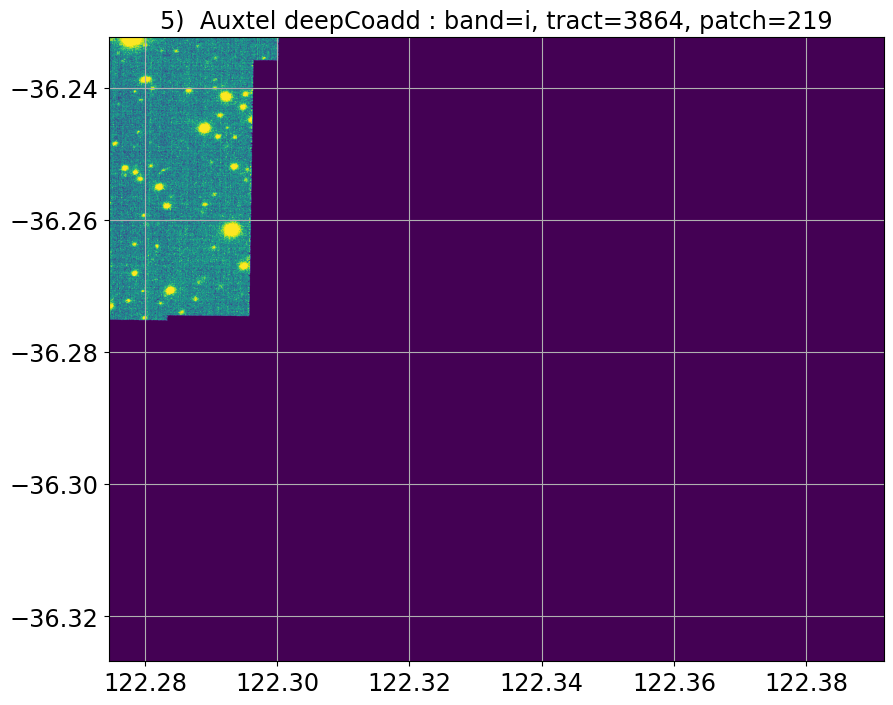

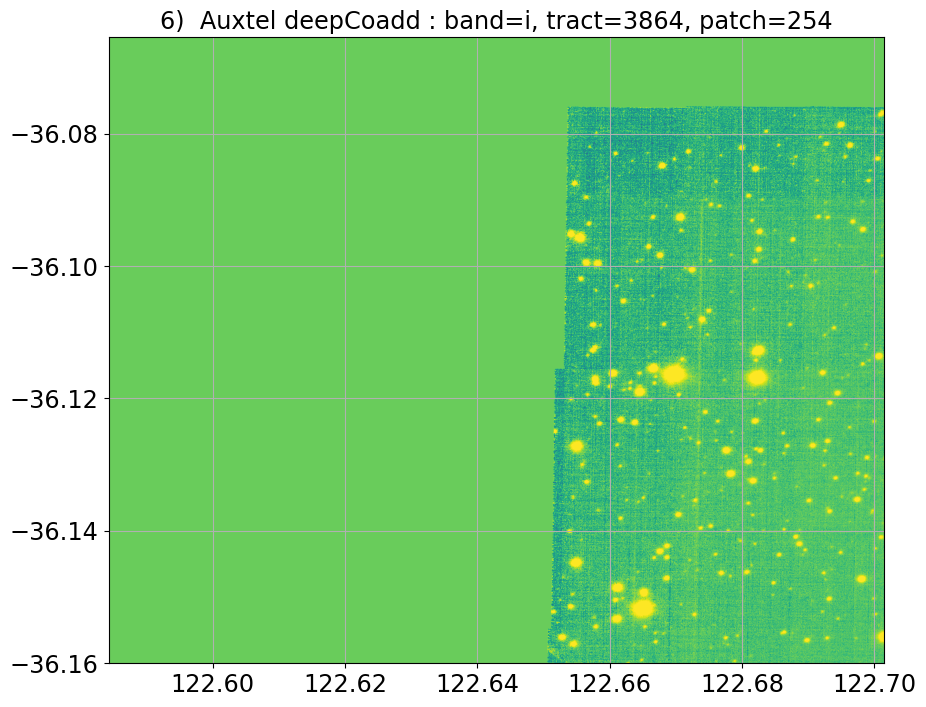

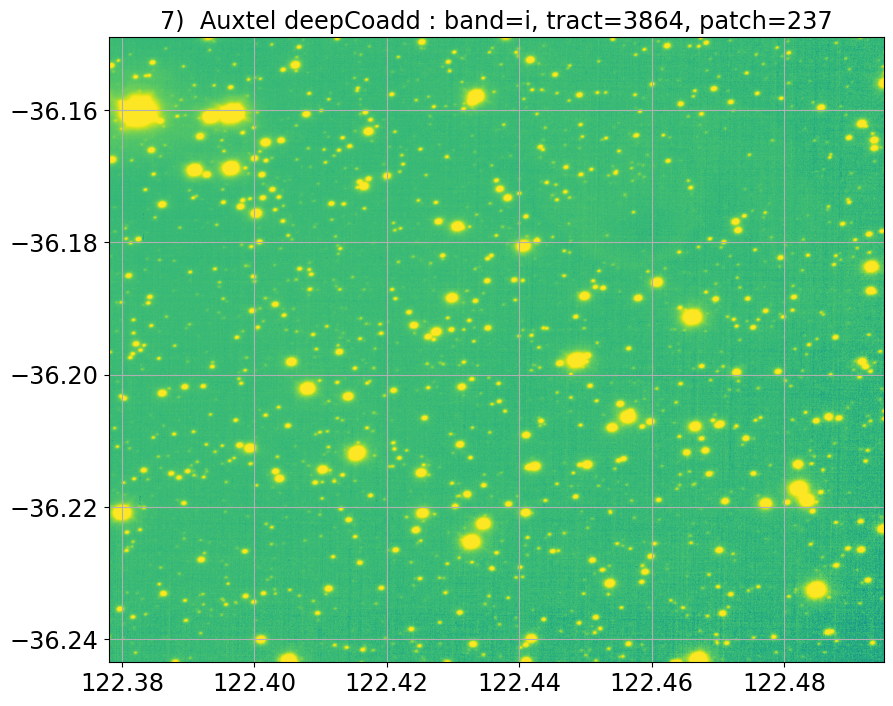

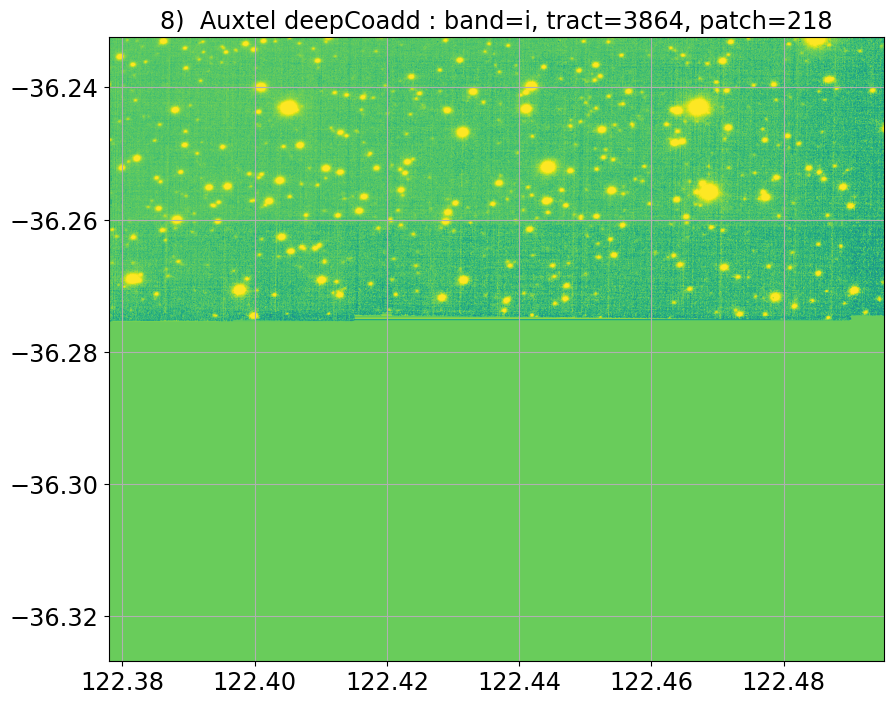

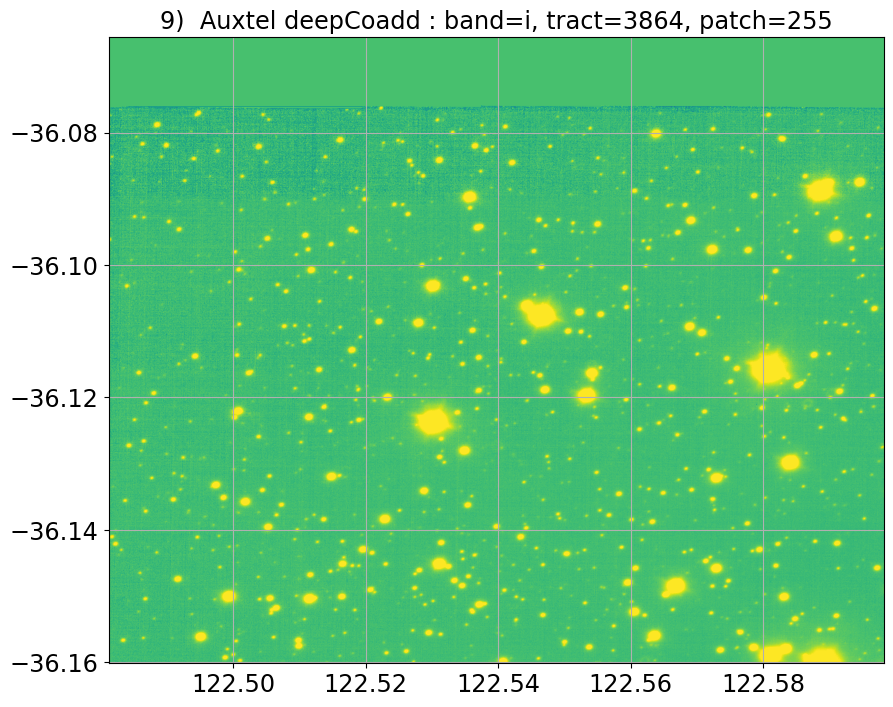

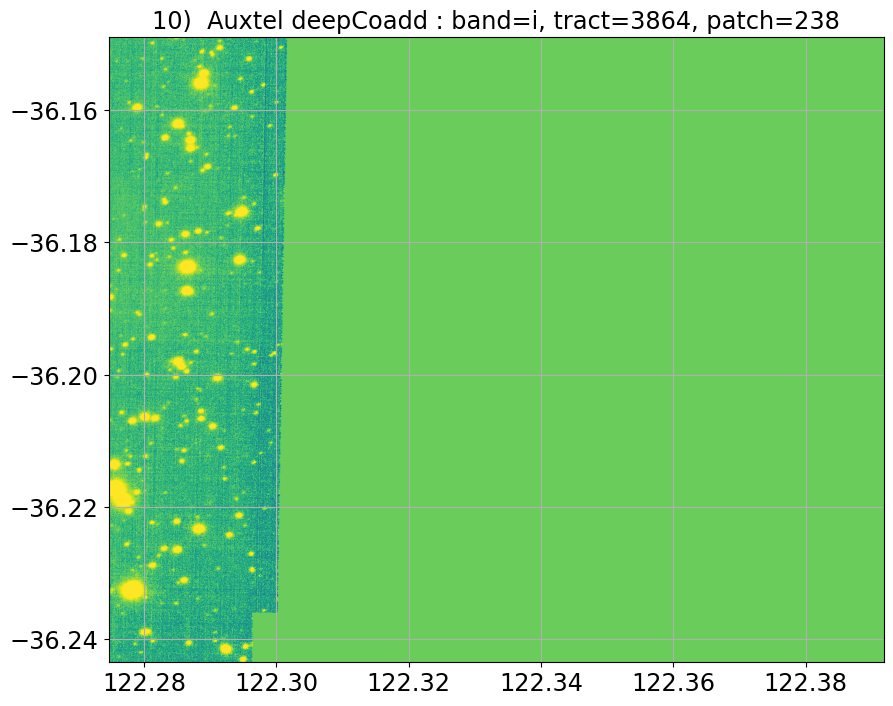

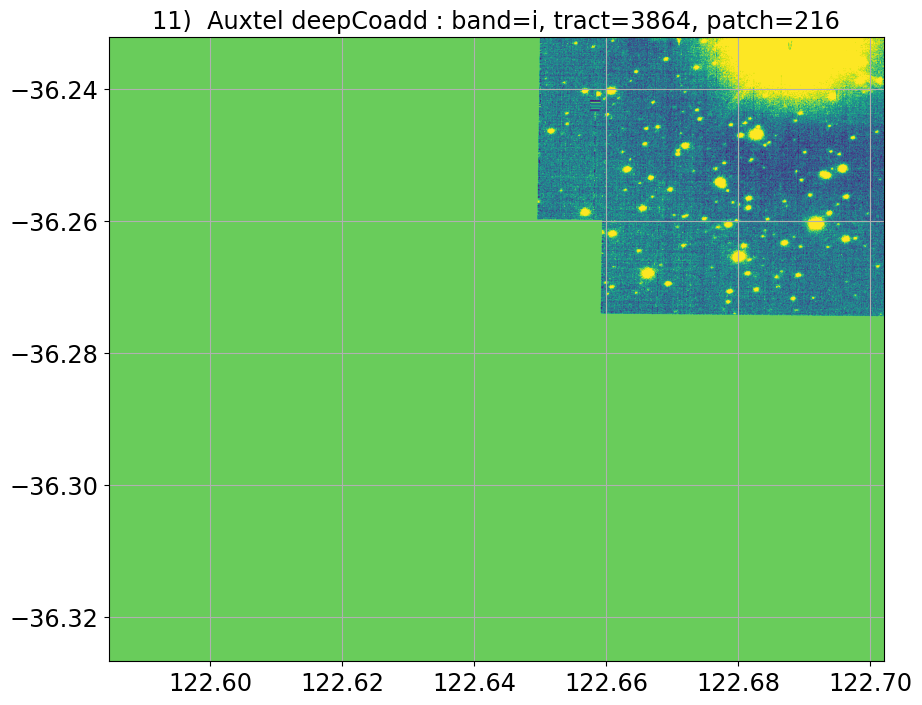

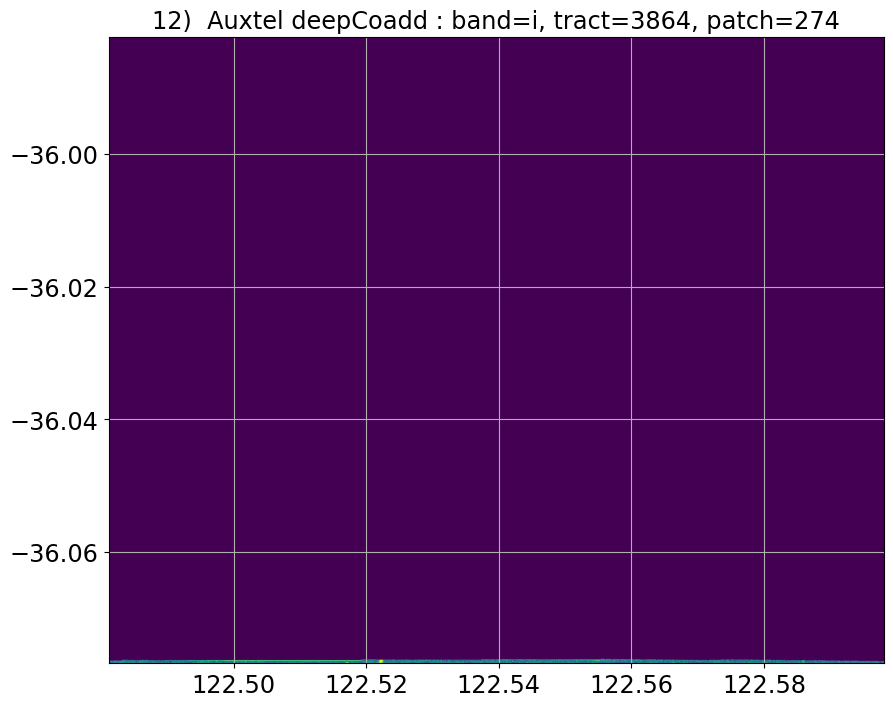

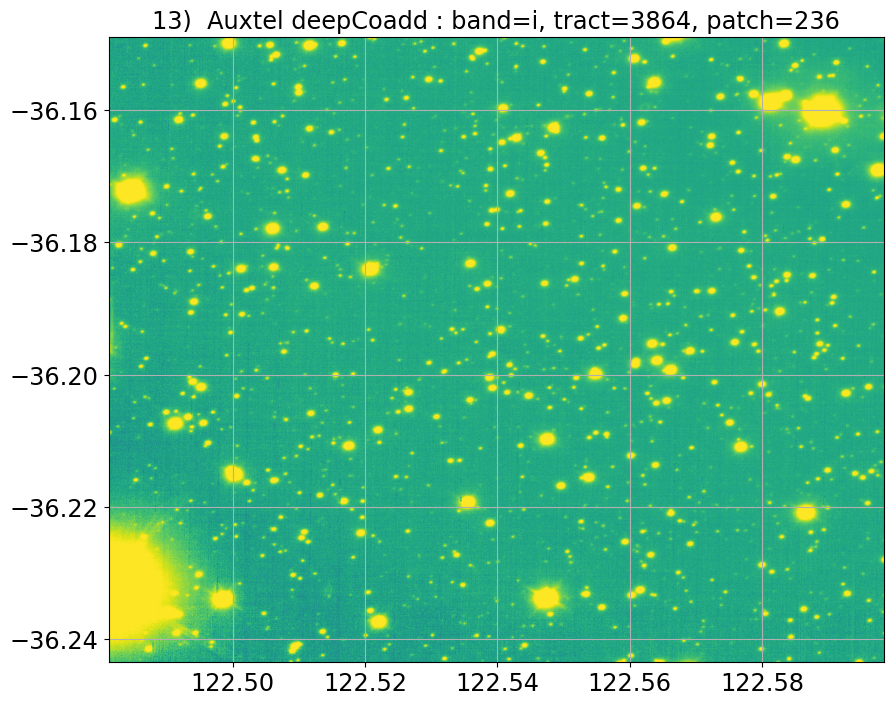

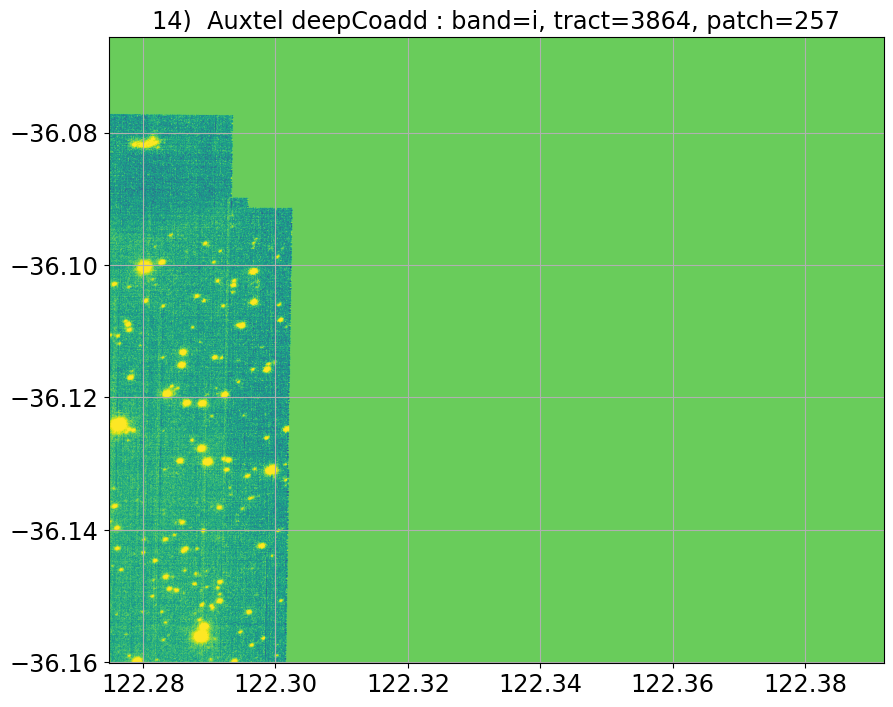

In [21]:
N = len(all_deepcoadds)

for index in range(N):
    the_dataid = all_dataId[index]
    the_deepcoadd = all_deepcoadds[index]
    the_title = f"{index})  "+all_titles[index]

    xvals = np.array(all_xvals[index])
    yvals = np.array(all_yvals[index])

    extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]
    
    # Plot the calexp we just retrieved
    plt.figure(figsize=(10,10))
    #afw_display = afwDisplay.Display()
    #afw_display.scale('asinh', 'zscale')
    #afw_display.mtv(the_deepcoadd.image,title=the_title )
    #plt.gca().axis('on')
    transform = AsinhStretch() + ZScaleInterval()
    scaledImage = transform(the_deepcoadd.image.array)
    #scaledImage = np.flipud(scaledImage)
    plt.imshow(scaledImage,origin="lower",extent=extent,aspect='equal')
    plt.title(the_title)
    plt.grid()
    #plt.gca().invert_xaxis()
    plt.show()
